In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

def plot_graph(components, x, my_title="Facial Netowork Chart", filename="faces.png", rotate90=False):
    n, m = x.shape
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.set_title(my_title)

    if (rotate90):
        # Show 40 of the images ont the plot
        x_size = (max(components[:, 1]) - min(components[:, 1])) * 0.06
        y_size = (max(components[:, 0]) - min(components[:, 0])) * 0.08

        for i in range(40):
            img_num = np.random.randint(0, m)
            x0 = components[img_num, 1] - (x_size / 2.)
            y0 = components[img_num, 0] - (y_size / 2.)
            x1 = components[img_num, 1] + (x_size / 2.)
            y1 = components[img_num, 0] + (y_size / 2.)
            img = x[:, img_num].reshape(64, 64).T
            ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

        # Show 2D components plot
        ax.scatter(components[:, 1], components[:, 0], marker='.',alpha=0.7)
            
    else:
        # Show 40 of the images ont the plot
        x_size = (max(components[:, 0]) - min(components[:, 0])) * 0.06
        y_size = (max(components[:, 1]) - min(components[:, 1])) * 0.08

        for i in range(40):
            img_num = np.random.randint(0, m)
            x0 = components[img_num, 0] - (x_size / 2.)
            y0 = components[img_num, 1] - (y_size / 2.)
            x1 = components[img_num, 0] + (x_size / 2.)
            y1 = components[img_num, 1] + (y_size / 2.)
            img = x[:, img_num].reshape(64, 64).T
            ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

        # Show 2D components plot
        ax.scatter(components[:, 0], components[:, 1], marker='.',alpha=0.7)


    ax.set_ylabel('Up-Down Pose')
    ax.set_xlabel('Right-Left Pose')

    #plt.savefig('img/'+filename)
    plt.show()
    return None

In [3]:
import scipy.io
mat = scipy.io.loadmat('isomap.mat')



In [4]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Sep 11 16:44:56 2019',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[0.01617647, 0.01617647, 0.01617647, ..., 0.01617647, 0.01617647,
         0.01617647],
        [0.01617647, 0.01617647, 0.01617647, ..., 0.01617647, 0.01617647,
         0.01617647],
        [0.01617647, 0.01617647, 0.01617647, ..., 0.01617647, 0.01617647,
         0.01617647],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])}

In [5]:
flatten_images = mat['images']

In [6]:
flatten_images.shape

(4096, 698)

In [7]:
from sklearn.manifold import Isomap
embedding = Isomap(n_neighbors=5, n_components=2)
X_transformed = embedding.fit_transform(flatten_images.T)

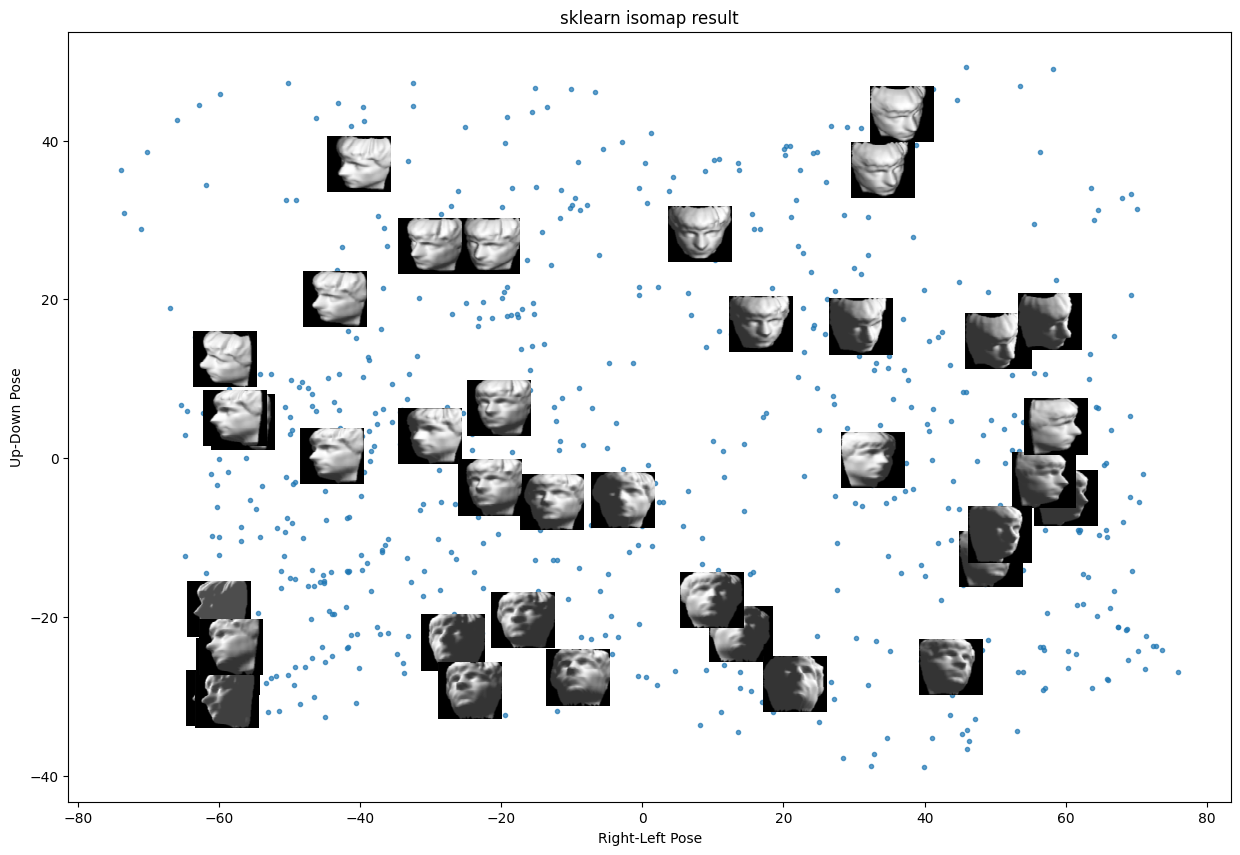

In [8]:
plot_graph(X_transformed, x=flatten_images, my_title="sklearn isomap result")

In [9]:
def MDS (city_distances, k):
    A = np.asarray(city_distances)
    Atild = np.power(A, 2)
    n, _ = A.shape
    e = np.ones((n,1))
    L = np.subtract(np.identity(n), 1/n*(np.dot(e, e.T)))
    B = -1/2 * np.dot(np.dot(L, Atild), L)
    B = 1/2 * (B + B.T)

    vals, vecs = np.linalg.eig(B)
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    # landa = np.zeros((len(vals), len(vals)))
    # np.fill_diagonal(landa, vals)
    # print(np.dot(np.dot(vecs, landa), vecs.T))
    non_negative_vals = np.where(vals < 0, np.zeros_like(vals), vals)
    non_negative_vals_square_root = np.power(non_negative_vals, 1/2)

    landa = np.zeros((k, k))
    np.fill_diagonal(landa, non_negative_vals_square_root[-k:])
    X = np.dot(vecs[:, -k:], landa)

    return(X)

In [10]:
def floydWarshall(graph):

    dist = np.copy(graph)
    V = len(dist)
    for k in range(V):
 
        # pick all vertices as source one by one
        for i in range(V):
 
            # Pick all vertices as destination for the
            # above picked source
            for j in range(V):
 
                # If vertex k is on the shortest path from
                # i to j, then update the value of dist[i][j]
                dist[i][j] = min(dist[i][j],
                                 dist[i][k] + dist[k][j]
                                 )
    return(dist)


In [11]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import floyd_warshall

def find_geodesic_distance(city_distances, num):

    knn = kneighbors_graph(city_distances, num, mode='distance', include_self='auto')
    
    # z = np.array(knn.todense(), dtype=np.float64)
    # z[z==0.0] = np.inf
    # for i in range(len(z)):
    #     z[i,i] = 0
    # A = floydWarshall(z)

    dist_matrix = floyd_warshall(csgraph=knn, directed=False)

    return(dist_matrix)

In [12]:
kneighbors_graph(flatten_images.T, 5, mode='distance', include_self='auto')

<698x698 sparse matrix of type '<class 'numpy.float64'>'
	with 3490 stored elements in Compressed Sparse Row format>

In [13]:
A = find_geodesic_distance(flatten_images.T, 5)
X = MDS(A, 2)

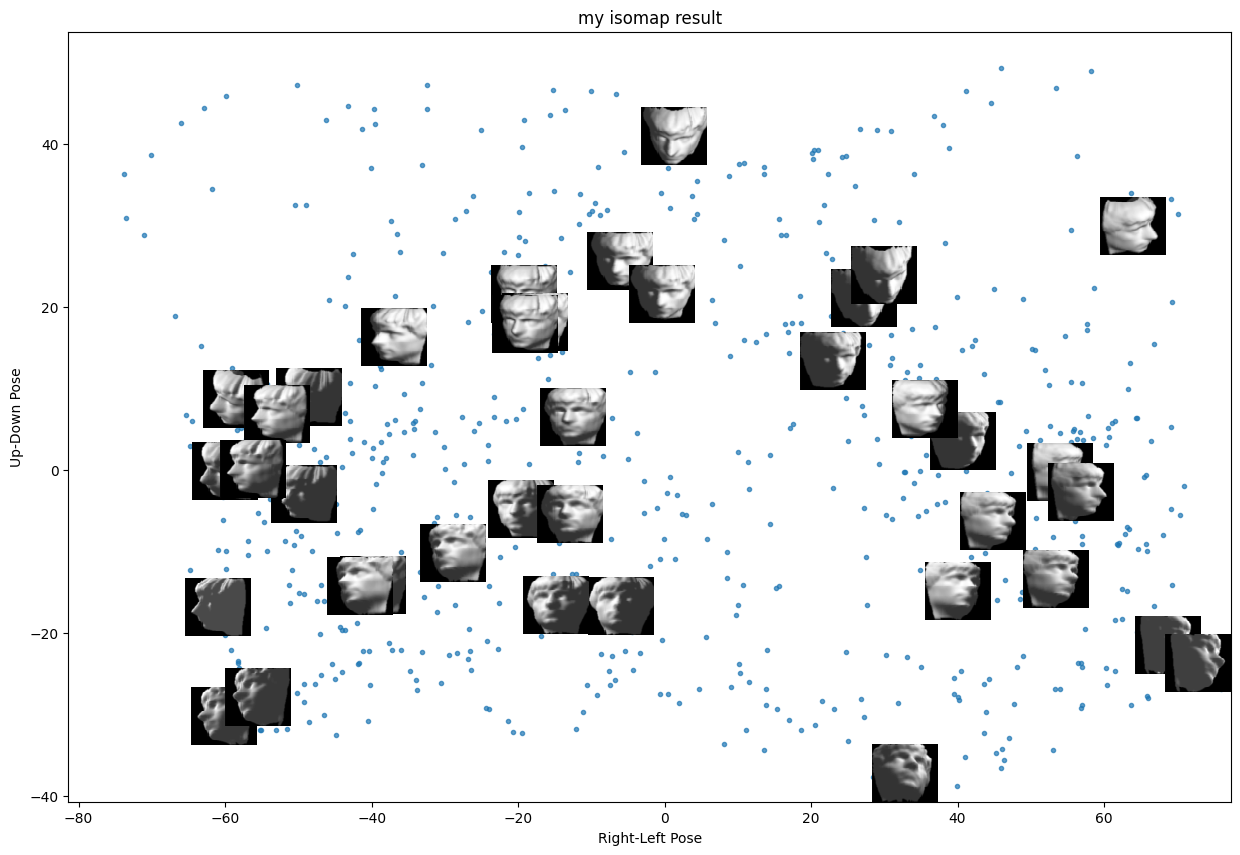

In [14]:
plot_graph(X, x=flatten_images, my_title="my isomap result", rotate90=True)